In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('..')
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from utils import *

In [370]:
config_features = {
    'use_holidays': True,
    'boxcox': True,
    'past_info': True,
    'scale_features': True
    }

model_params = { 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor',
    'objective': 'reg:pseudohubererror','colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 12, 'n_estimators': 200, 'subsample': 0.5, 'reg_alpha': 0, 'reg_lambda': 0.5, 'gamma': 0.1
    }


In [371]:
df_first = pd.read_csv(r'data\cleaned_data\5_household\power\SFH36_demand_W.csv', index_col=0, parse_dates=True)



df_first = pd.read_csv(r"C:\Users\nik\iCloudDrive\PhD_Icloud\PhD_Papers\Berkeley\Data\load_data_15min_watts.csv", index_col=0, parse_dates=True).iloc[:,-1:]

# TODO add these steps to data prep notebook

#-----------------------#
df = remove_duplicate_index(df_first)

df[df<=0] = 1e-6 # because of log transform

#-----------------------#

if config_features['boxcox']:
    df, lam = boxcox_transform(df)


scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])
df = timeseries_dataframe_pivot(df).dropna()
n_timesteps_per_day = df.shape[1]


In [372]:
df.shape

(293, 96)

In [373]:
# past information
lagged_days = 7
if config_features['past_info']:
    df = calc_rolling_sum_of_load(df, 7)
    df["load_of_last_day"] = df.iloc[:,:n_timesteps_per_day].sum(axis=1).shift(1)
    for i in range(2,lagged_days+1):
        df = pd.concat([df, df.iloc[:,:n_timesteps_per_day].shift(i)],axis=1).dropna()


In [374]:
years = get_year_list(df)
df_holidays_dummies = get_holidays(years, "AT")
df_holidays = create_holiday_features(df, df_holidays_dummies)
df = pd.concat([df, df_holidays], axis=1)

In [375]:
df = create_datetime_features(df)
df_final = df.astype('float32').iloc[:-1,:]
n_features = df_final.shape[1] - n_timesteps_per_day
n_timesteps = df_final.shape[0] * n_timesteps_per_day

In [376]:

# split the data into train and test

test_size = 0.2
train, test = train_test_split(df_final, test_size=test_size, shuffle=False)
test_idx = unpivot_timeseries_dataframe(test.iloc[:, :n_timesteps_per_day]).index
train = train.values
test = test.values

#features and target
X_train = train[:,n_timesteps_per_day:]
y_train = train[:,:n_timesteps_per_day]

X_test = test[:,n_timesteps_per_day:]
y_test = test[:,:n_timesteps_per_day]

# scale the data
if config_features['scale_features']:
    scaler_features = MinMaxScaler()
    X_train = scaler_features.fit_transform(X_train)
    X_test = scaler_features.transform(X_test)

# define the model
model = XGBRegressor(
    **model_params
    )


In [377]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             objective='reg:pseudohubererror', predictor='gpu_predictor', ...)

In [378]:
predictions = model.predict(X_test)
predictions_reshaped = predictions.reshape(-1,1).flatten()
predictions_reshaped[predictions_reshaped < 0] = 0 # removing negative values
# reverse the scaling and boxcox transformation of the predictions
predictions_reshaped = scaler.inverse_transform(predictions_reshaped.reshape(-1,1)).flatten()
if config_features['boxcox']:
    predictions_reshaped = inverse_boxcox_transform(pd.DataFrame(predictions_reshaped), lam).values.flatten()


In [379]:
# create the persistence benchmarks
gt = df_first.loc[test_idx]
benchmark_day = gt.shift(n_timesteps_per_day).fillna(0).values.flatten() # previous day
benchmark_week = gt.shift(n_timesteps_per_day*7).fillna(0).values.flatten() # same day of previous week

gt = gt.values.flatten()


### Visualization for the resolution

In [380]:
df_compare = pd.DataFrame({'gt':gt, 
                            'predictions': predictions_reshaped,
                            'benchmark_day': benchmark_day,
                            'benchmark_week': benchmark_week}
                            )[96*7:]

px.line(df_compare,  title='XGBoost Regression')

In [381]:
df_metrics = calc_metrics(df_compare, [mean_squared_error,mean_absolute_error, r2_score])
df_metrics


,root_mean_squared_error,mean_absolute_error,r2_score
predictions,406.605288,204.983072,-2.225386
benchmark_day,481.286671,229.843285,-0.561386
benchmark_week,499.224570,245.908364,-0.657477


### Visualization For Daily Energy

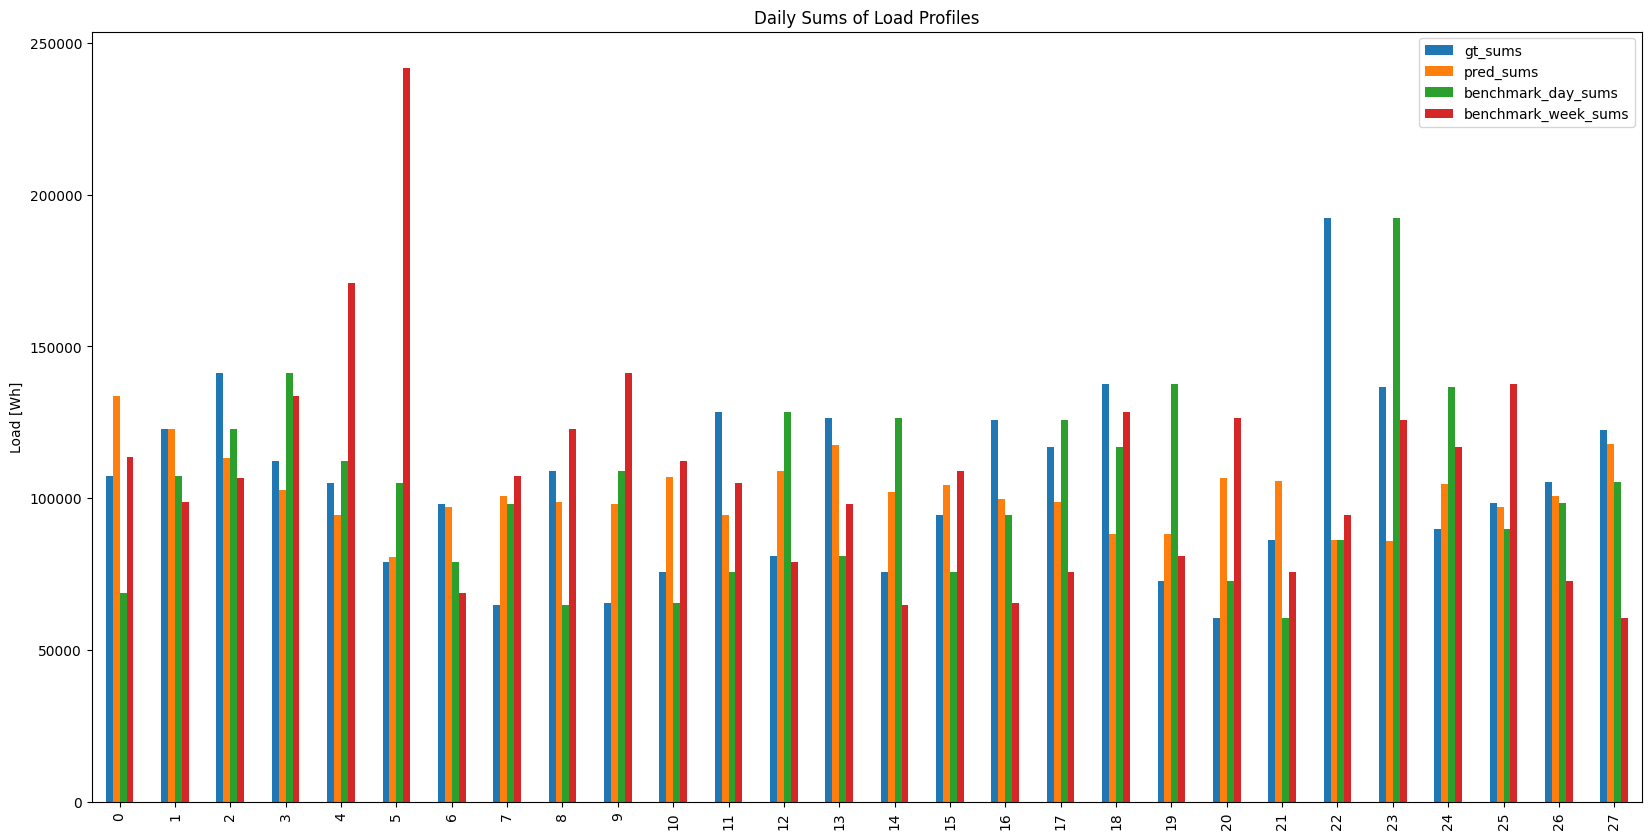

In [356]:
benchmark_day_per_day = benchmark_day.reshape(predictions.shape)[7:]
benchmark_week_per_day = benchmark_week.reshape(predictions.shape)[7:]
predictions_per_day = predictions_reshaped.reshape(predictions.shape)[7:].sum(axis=1)
gt_per_day = gt.reshape(predictions.shape)[7:].sum(axis=1)


df_daily_sum = pd.DataFrame({ 
                            'gt_sums':gt_per_day,
                            'pred_sums': predictions_per_day,
                            'benchmark_day_sums': benchmark_day_per_day.sum(axis=1),
                            'benchmark_week_sums': benchmark_week_per_day.sum(axis=1)
                             })[:28] * 4



df_daily_sum.plot(title='Daily Sums of Load Profiles', kind='bar', figsize=(20,10))
plt.ylabel('Load [Wh]')
plt.show()

In [357]:
df_metrics_daily = calc_metrics(df_daily_sum, [mean_squared_error,mean_absolute_error, r2_score])
df_metrics_daily

,root_mean_squared_error,mean_absolute_error,r2_score
pred_sums,31807.895341,23294.429762,-6.588424
benchmark_day_sums,39033.249348,32359.395918,-0.765949
benchmark_week_sums,50563.713495,37744.213893,-0.851204


### Tuning hyperparameters

In [49]:
# Define the XGBoost model and the objective function for Bayesian optimization
def xgb_cv(objective, learning_rate, n_estimators, max_depth, subsample, colsample_bytree):
    xgb_model = xgb.XGBRegressor(
        tree_method = "gpu_hist",
        objective=objective,
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        eval_metric="rmse")
    
    return -1 * np.mean(cross_val_score(xgb_model, X_train, y_train, cv=3, scoring="neg_mean_squared_error"))

# Define the hyperparameter space for Bayesian optimization

xgbBO = BayesianOptimization(
    xgb_cv,
    {   
    
        "objective": ["reg:squarederror", "reg:pseudohubererror"]
        "learning_rate": (0.01, 0.5),
        "n_estimators": (50, 1000),
        "max_depth": (3, 12),
        "subsample": (0.5, 1),
        "colsample_bytree": (0.5, 1),
    },
    random_state=42,
)

# Run Bayesian optimization for a certain number of iterations
xgbBO.maximize(n_iter=100, init_points=2)

# Print the best set of hyperparameters found by Bayesian optimization
print(xgbBO.max)


|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | 0.01884   | 0.6873    | 0.2857    | 8.124     | 199.7     | 0.578     |
| 2         | 0.01557   | 0.578     | 0.02684   | 9.063     | 200.3     | 0.854     |
| 3         | 0.01688   | 0.6948    | 0.1129    | 8.102     | 199.5     | 0.9566    |
| 4         | 0.01667   | 0.9532    | 0.04055   | 4.031     | 281.3     | 0.8854    |
| 5         | 0.01426   | 0.792     | 0.02386   | 3.251     | 76.13     | 0.6166    |
| 6         | 0.01948   | 0.7984    | 0.2845    | 8.016     | 199.4     | 0.5147    |
| 7         | 0.01718   | 0.5313    | 0.115     | 7.899     | 198.7     | 0.6182    |
| 8         | 0.02013   | 1.0       | 0.3       | 8.413     | 199.3     | 0.5       |
| 9         | 0.01926   | 0.9129    | 0.26      | 8.997     | 199.1     | 0.5059    |
| 10        | 0.01853   | 0.8943    | 0.2202    | 9.43